In [1]:
from torchvision import transforms, datasets, models
import torch
import torchvision
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.utils.data as data
import gc
import cv2
import os
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [8]:
#Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
images_path = "/kaggle/input/d/biraaj027/wild-animals-dataset/data/size_512"

In [10]:
#Applying Image Tranformations
transformer = transforms.Compose(
    [
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
dataset = ImageFolder(images_path, transform=transformer)

In [11]:
# Here the classes are recognized according to folder structure if we use ImageFolder from torchvison.
total_class = dataset.classes
print(total_class)

['cheetah', 'fox', 'hyena', 'lion', 'tiger', 'wolf']


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


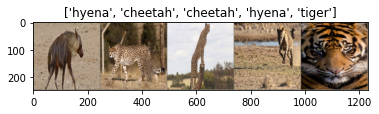

In [8]:
# Viewing Image After Transformation
def show_image(_input, _classes=None):
    input = _input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if _classes is not None:
        plt.title(_classes)
    plt.pause(0.002)
dataloader_to_view = data.DataLoader(dataset, batch_size=5, shuffle=True, num_workers=10)
# Getting samples of dataset
inputs, classes = next(iter(dataloader_to_view))
output_image_prepreprocessed = torchvision.utils.make_grid(inputs)
show_image(output_image_prepreprocessed, _classes=[total_class[y] for y in classes])

In [12]:
print(len(dataset))

1723


In [13]:
# Random split (train:6 valid:2 test:2)
train_set_size = int(len(dataset) * 0.6)
valid_set_size = int(len(dataset)*0.2)+1
test_set_size = valid_set_size
print(train_set_size,valid_set_size,test_set_size)

1033 345 345


In [14]:
train_set, valid_set, test_set = data.random_split(dataset, [train_set_size, valid_set_size, test_set_size])

In [15]:
# Training Sampler
## Collecting all the indices that the training set contains.
train_indices = train_set.indices

#Collecting the list with image target ['cheetah':0, 'fox':1, 'hyena':2, 'lion':3, 'tiger':4, 'wolf':5]
train_list = [dataset.targets[i] for i in train_indices]

# Sample count for each class
train_class_sample_count = np.array(
    [len(np.where(train_list == t)[0]) for t in np.unique(train_list)])

In [16]:
train_class_sample_count

array([211, 155, 181, 175, 159, 152])

In [17]:
# Finding weight of each class
train_weight = 1/ train_class_sample_count

# Assigning weight to each index
train_samples_weight = np.array([train_weight[t] for t in train_list])
train_samples_weight = torch.from_numpy(train_samples_weight)

In [18]:
# Validation Sampler
valid_indices = valid_set.indices

valid_list = [dataset.targets[i] for i in valid_indices]

valid_class_sample_count = np.array(
    [len(np.where(valid_list == t)[0]) for t in np.unique(valid_list)])

In [19]:
valid_weight = 1/ valid_class_sample_count
valid_samples_weight = np.array([valid_weight[t] for t in valid_list])
valid_samples_weight = torch.from_numpy(valid_samples_weight)

In [20]:
#Balancing imbalanced classes
train_sampler = WeightedRandomSampler(train_samples_weight.type('torch.DoubleTensor'), len(train_samples_weight))
valid_sampler = WeightedRandomSampler(valid_samples_weight.type('torch.DoubleTensor'), len(valid_samples_weight))

In [21]:
train_samples_weight

tensor([0.0065, 0.0047, 0.0047,  ..., 0.0065, 0.0055, 0.0065],
       dtype=torch.float64)

In [22]:
# Loading data into RAM
train_dataloader = data.DataLoader(train_set, batch_size=4, sampler=train_sampler)
valid_dataloader = data.DataLoader(valid_set, batch_size=4, sampler=valid_sampler)
test_dataloader = data.DataLoader(test_set, batch_size=4)

In [20]:
# VGG16
class VGG16(nn.Module):
    def __init__(self, classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, classes))
        
    def forward(self, x):
        res = self.layer1(x)
        res = self.layer2(res)
        res = self.layer3(res)
        res = self.layer4(res)
        res = self.layer5(res)
        res = self.layer6(res)
        res = self.layer7(res)
        res = self.layer8(res)
        res = self.layer9(res)
        res = self.layer10(res)
        res = self.layer11(res)
        res = self.layer12(res)
        res = self.layer13(res)
        res = res.reshape(res.size(0), -1)
        res = self.fc(res)
        res = self.fc1(res)
        res = self.fc2(res)
        return res

In [23]:
def train(model, epochs, optimizer):
    total_step = len(train_dataloader)
    training_loss_values = []
    validation_loss_values = []

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, (images, labels) in tqdm(enumerate(train_dataloader)):  
            # Loading tensor into configured device
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss = running_loss + loss.item() 

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            
        training_loss_values.append(running_loss/train_set_size)

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, epochs, i+1, total_step, loss.item()))

        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in tqdm(valid_dataloader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss = running_loss + loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            validation_loss_values.append(running_loss/train_set_size)

        print('model accuracy on {} validation images = {} %'.format(345, 100 * correct / total))
    return model, training_loss_values, validation_loss_values

In [24]:
def test_accuracy(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            tensors, predicted = torch.max(outputs.data, 1)
            total = total + labels.size(0)
            correct = correct + (predicted == labels).sum().item()
            del images, labels, outputs
        
        print('model accuracy on the {} test images: {} %'.format(345, 100 * correct / total)) 

In [106]:
# Hyper parameter Tuning

classes = 6
epochs = 10
batch_size = 50
learning_rate = 0.002
historical_result = []

model1 = VGG16(classes).to(device)

# Loss function and optimizer
criterion  = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.2)  

In [25]:
def plot_loss_graph(train,valid,title):
    plt.plot(train, label="train")
    plt.plot(valid, label="valid")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title(title)
    plt.show()

In [102]:
#Test1 learning rate: 0.005, batch size:100, momentum: 0.5, weight_decay: 0.005
model1, train_loss1, valid_loss1 = train(model1,epochs,optimizer1)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/10], Step [259/259], Loss: 1.8188


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 36.231884057971016 %


0it [00:00, ?it/s]

Epoch [2/10], Step [259/259], Loss: 1.9891


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 36.52173913043478 %


0it [00:00, ?it/s]

Epoch [3/10], Step [259/259], Loss: 1.6825


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 33.91304347826087 %


0it [00:00, ?it/s]

Epoch [4/10], Step [259/259], Loss: 2.1570


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 40.289855072463766 %


0it [00:00, ?it/s]

Epoch [5/10], Step [259/259], Loss: 1.1416


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 39.710144927536234 %


0it [00:00, ?it/s]

Epoch [6/10], Step [259/259], Loss: 0.5868


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 48.98550724637681 %


0it [00:00, ?it/s]

Epoch [7/10], Step [259/259], Loss: 1.3989


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 53.04347826086956 %


0it [00:00, ?it/s]

Epoch [8/10], Step [259/259], Loss: 0.7464


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 60.0 %


0it [00:00, ?it/s]

Epoch [9/10], Step [259/259], Loss: 2.3982


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 57.971014492753625 %


0it [00:00, ?it/s]

Epoch [10/10], Step [259/259], Loss: 1.5686


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 50.72463768115942 %


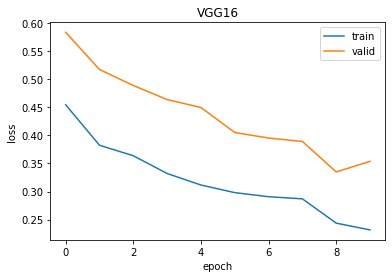

In [103]:
plot_loss_graph(train_loss1,valid_loss1,"VGG16")

In [104]:
test_accuracy(model1)

model accuracy on the 345 test images: 57.971014492753625 %


In [107]:
## Test2 learning rate: 0.002, batch size:50, momentum: 0.2, weight_decay: 0.005
model1, train_loss1, valid_loss1 = train(model1,epochs,optimizer1)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/10], Step [259/259], Loss: 1.1043


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 37.391304347826086 %


0it [00:00, ?it/s]

Epoch [2/10], Step [259/259], Loss: 2.1853


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 37.10144927536232 %


0it [00:00, ?it/s]

Epoch [3/10], Step [259/259], Loss: 1.8465


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 47.82608695652174 %


0it [00:00, ?it/s]

Epoch [4/10], Step [259/259], Loss: 1.9272


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 44.63768115942029 %


0it [00:00, ?it/s]

Epoch [5/10], Step [259/259], Loss: 1.7085


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 49.27536231884058 %


0it [00:00, ?it/s]

Epoch [6/10], Step [259/259], Loss: 0.5877


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 59.130434782608695 %


0it [00:00, ?it/s]

Epoch [7/10], Step [259/259], Loss: 3.1192


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 57.10144927536232 %


0it [00:00, ?it/s]

Epoch [8/10], Step [259/259], Loss: 0.2108


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 60.869565217391305 %


0it [00:00, ?it/s]

Epoch [9/10], Step [259/259], Loss: 1.0913


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 48.69565217391305 %


0it [00:00, ?it/s]

Epoch [10/10], Step [259/259], Loss: 0.0699


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 59.130434782608695 %


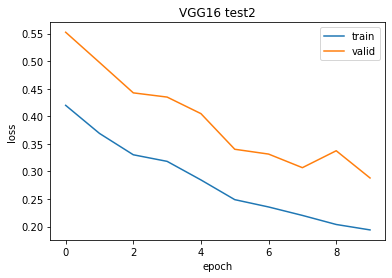

In [108]:
plot_loss_graph(train_loss1,valid_loss1,"VGG16 test2")

In [109]:
test_accuracy(model1)

model accuracy on the 345 test images: 60.289855072463766 %


In [41]:
#### Resnet Implementation.
## Class for residual block
class ResBlk(nn.Module):
    def __init__(self, input_chan, output_chan, stride = 1, downsample = None):
        super(ResBlk, self).__init__()
        self.convolution_layer1 = nn.Sequential(
                        nn.Conv2d(input_chan, output_chan, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(output_chan),
                        nn.ReLU())
        self.convolution_layer2 = nn.Sequential(
                        nn.Conv2d(output_chan, output_chan, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(output_chan))
        self.output_chan = output_chan
        self.relu_activation = nn.ReLU()
        self._downsampler = downsample
        
    def forward(self, z):
        weight_residual = z
        _output = self.convolution_layer1(z)
        _output = self.convolution_layer2(_output)
        if self._downsampler:
            weight_residual = self._downsampler(z)
        _output += weight_residual
        _output = self.relu_activation(_output)
        return _output




class ResNet34(nn.Module):
    def __init__(self, block, layers, classes):
        super(ResNet34, self).__init__()
        self.input_planes = 64
        self.convolution_layer1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpooling = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.block_layer0 = self.create_layer(block, 64, layers[0], stride = 1)
        self.block_layer1 = self.create_layer(block, 128, layers[1], stride = 2)
        self.block_layer2 = self.create_layer(block, 256, layers[2], stride = 2)
        self.block_layer3 = self.create_layer(block, 512, layers[3], stride = 2)
        self.averagepool = nn.AvgPool2d(7, stride=1)
        self.fullyConnected = nn.Linear(2048, classes)
        
    def create_layer(self, block, planes, blocks, stride=1):
        _down_sample = None
        if stride != 1 or self.input_planes != planes:
            _down_sample = nn.Sequential(
                nn.Conv2d(self.input_planes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
            
        block_layers = []
        block_layers.append(block(self.input_planes, planes, stride, _down_sample))
        self.input_planes = planes
        for i in range(1, blocks):
            block_layers.append(block(self.input_planes, planes))

        return nn.Sequential(*block_layers)
    
    
    def forward(self, z):
        z = self.convolution_layer1(z)
        z = self.maxpooling(z)
        z = self.block_layer0(z)
        z = self.block_layer1(z)
        z = self.block_layer2(z)
        z = self.block_layer3(z)

        z = self.averagepool(z)
        z = z.view(z.size(0), -1)
        z = self.fullyConnected(z)

        return z

In [42]:
# Hyper parameter Tuning for resnet

classes = 6
epochs = 50
batch_size = 50
learning_rate = 0.005
historical_result = []

model2 = ResNet34(ResBlk,[3, 4, 6, 3],classes).to(device)

# Loss function and optimizer
criterion  = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.2)  

In [36]:
## Test3 learning rate: 0.02, batch size:20, momentum: 0.5, weight_decay: 0.005
model2, train_loss2, valid_loss2 = train(model2,epochs,optimizer2)

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1/15], Step [259/259], Loss: 2.8690


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 15.652173913043478 %


0it [00:00, ?it/s]

Epoch [2/15], Step [259/259], Loss: 0.5674


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 18.840579710144926 %


0it [00:00, ?it/s]

Epoch [3/15], Step [259/259], Loss: 2.9168


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 21.73913043478261 %


0it [00:00, ?it/s]

Epoch [4/15], Step [259/259], Loss: 1.7646


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 18.26086956521739 %


0it [00:00, ?it/s]

Epoch [5/15], Step [259/259], Loss: 1.6585


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 17.391304347826086 %


0it [00:00, ?it/s]

Epoch [6/15], Step [259/259], Loss: 2.4018


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 20.869565217391305 %


0it [00:00, ?it/s]

Epoch [7/15], Step [259/259], Loss: 2.0975


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 24.92753623188406 %


0it [00:00, ?it/s]

Epoch [8/15], Step [259/259], Loss: 1.1980


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 23.47826086956522 %


0it [00:00, ?it/s]

Epoch [9/15], Step [259/259], Loss: 1.8662


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 22.028985507246375 %


0it [00:00, ?it/s]

Epoch [10/15], Step [259/259], Loss: 1.4188


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 24.057971014492754 %


0it [00:00, ?it/s]

Epoch [11/15], Step [259/259], Loss: 1.5988


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 30.144927536231883 %


0it [00:00, ?it/s]

Epoch [12/15], Step [259/259], Loss: 1.7648


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 26.3768115942029 %


0it [00:00, ?it/s]

Epoch [13/15], Step [259/259], Loss: 1.3961


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 26.956521739130434 %


0it [00:00, ?it/s]

Epoch [14/15], Step [259/259], Loss: 2.2733


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 28.115942028985508 %


0it [00:00, ?it/s]

Epoch [15/15], Step [259/259], Loss: 1.6380


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 30.72463768115942 %


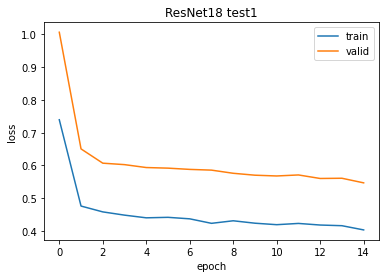

In [40]:
plot_loss_graph(train_loss2,valid_loss2,"ResNet18 test1")

In [42]:
test_accuracy(model2)

model accuracy on the 345 test images: 27.82608695652174 %


In [45]:
## Test4 learning rate: 0.005, batch size:50, momentum: 0.2, weight_decay: 0.005 epoch:20
model2, train_loss2, valid_loss2 = train(model2,epochs,optimizer2)

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/20], Step [259/259], Loss: 0.9194


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 16.52173913043478 %


0it [00:00, ?it/s]

Epoch [2/20], Step [259/259], Loss: 1.9784


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 20.28985507246377 %


0it [00:00, ?it/s]

Epoch [3/20], Step [259/259], Loss: 2.5783


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 32.7536231884058 %


0it [00:00, ?it/s]

Epoch [4/20], Step [259/259], Loss: 1.3243


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 35.072463768115945 %


0it [00:00, ?it/s]

Epoch [5/20], Step [259/259], Loss: 1.4761


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 25.797101449275363 %


0it [00:00, ?it/s]

Epoch [6/20], Step [259/259], Loss: 1.6410


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 26.3768115942029 %


0it [00:00, ?it/s]

Epoch [7/20], Step [259/259], Loss: 1.1635


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 35.94202898550725 %


0it [00:00, ?it/s]

Epoch [8/20], Step [259/259], Loss: 0.9914


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 44.927536231884055 %


0it [00:00, ?it/s]

Epoch [9/20], Step [259/259], Loss: 1.4999


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 42.028985507246375 %


0it [00:00, ?it/s]

Epoch [10/20], Step [259/259], Loss: 1.5573


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 41.44927536231884 %


0it [00:00, ?it/s]

Epoch [11/20], Step [259/259], Loss: 0.5337


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 51.88405797101449 %


0it [00:00, ?it/s]

Epoch [12/20], Step [259/259], Loss: 0.7846


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 51.88405797101449 %


0it [00:00, ?it/s]

Epoch [13/20], Step [259/259], Loss: 0.3628


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 49.85507246376812 %


0it [00:00, ?it/s]

Epoch [14/20], Step [259/259], Loss: 1.9757


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 45.507246376811594 %


0it [00:00, ?it/s]

Epoch [15/20], Step [259/259], Loss: 0.4404


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 55.36231884057971 %


0it [00:00, ?it/s]

Epoch [16/20], Step [259/259], Loss: 0.1935


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 66.3768115942029 %


0it [00:00, ?it/s]

Epoch [17/20], Step [259/259], Loss: 0.2127


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 61.73913043478261 %


0it [00:00, ?it/s]

Epoch [18/20], Step [259/259], Loss: 0.3874


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 74.20289855072464 %


0it [00:00, ?it/s]

Epoch [19/20], Step [259/259], Loss: 1.2957


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 62.31884057971015 %


0it [00:00, ?it/s]

Epoch [20/20], Step [259/259], Loss: 2.1379


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 55.94202898550725 %


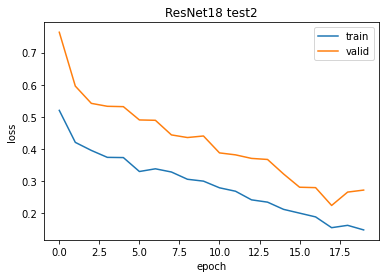

In [46]:
plot_loss_graph(train_loss2,valid_loss2,"ResNet18 test2")

In [48]:
test_accuracy(model2)

model accuracy on the 345 test images: 50.43478260869565 %


In [50]:
## Test4 learning rate: 0.005, batch size:50, momentum: 0.2, weight_decay: 0.005 epoch:50
model2, train_loss2, valid_loss2 = train(model2,epochs,optimizer2)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/50], Step [259/259], Loss: 2.9445


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 28.985507246376812 %


0it [00:00, ?it/s]

Epoch [2/50], Step [259/259], Loss: 1.5665


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 16.231884057971016 %


0it [00:00, ?it/s]

Epoch [3/50], Step [259/259], Loss: 1.7851


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 31.884057971014492 %


0it [00:00, ?it/s]

Epoch [4/50], Step [259/259], Loss: 2.8221


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 29.565217391304348 %


0it [00:00, ?it/s]

Epoch [5/50], Step [259/259], Loss: 1.4298


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 40.0 %


0it [00:00, ?it/s]

Epoch [6/50], Step [259/259], Loss: 1.1831


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 38.55072463768116 %


0it [00:00, ?it/s]

Epoch [7/50], Step [259/259], Loss: 1.9547


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 39.710144927536234 %


0it [00:00, ?it/s]

Epoch [8/50], Step [259/259], Loss: 1.1678


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 48.98550724637681 %


0it [00:00, ?it/s]

Epoch [9/50], Step [259/259], Loss: 0.4129


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 49.27536231884058 %


0it [00:00, ?it/s]

Epoch [10/50], Step [259/259], Loss: 0.8180


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 44.34782608695652 %


0it [00:00, ?it/s]

Epoch [11/50], Step [259/259], Loss: 0.4163


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 55.072463768115945 %


0it [00:00, ?it/s]

Epoch [12/50], Step [259/259], Loss: 1.3518


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 44.63768115942029 %


0it [00:00, ?it/s]

Epoch [13/50], Step [259/259], Loss: 1.9477


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 53.91304347826087 %


0it [00:00, ?it/s]

Epoch [14/50], Step [259/259], Loss: 2.3162


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 56.52173913043478 %


0it [00:00, ?it/s]

Epoch [15/50], Step [259/259], Loss: 1.4387


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 51.30434782608695 %


0it [00:00, ?it/s]

Epoch [16/50], Step [259/259], Loss: 1.9917


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 43.47826086956522 %


0it [00:00, ?it/s]

Epoch [17/50], Step [259/259], Loss: 2.0952


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 49.56521739130435 %


0it [00:00, ?it/s]

Epoch [18/50], Step [259/259], Loss: 1.2471


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 42.89855072463768 %


0it [00:00, ?it/s]

Epoch [19/50], Step [259/259], Loss: 0.6474


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 61.15942028985507 %


0it [00:00, ?it/s]

Epoch [20/50], Step [259/259], Loss: 2.1448


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 60.57971014492754 %


0it [00:00, ?it/s]

Epoch [21/50], Step [259/259], Loss: 1.7774


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 49.27536231884058 %


0it [00:00, ?it/s]

Epoch [22/50], Step [259/259], Loss: 1.3375


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 62.31884057971015 %


0it [00:00, ?it/s]

Epoch [23/50], Step [259/259], Loss: 0.0172


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 66.08695652173913 %


0it [00:00, ?it/s]

Epoch [24/50], Step [259/259], Loss: 0.0492


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 74.4927536231884 %


0it [00:00, ?it/s]

Epoch [25/50], Step [259/259], Loss: 0.1440


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 70.72463768115942 %


0it [00:00, ?it/s]

Epoch [26/50], Step [259/259], Loss: 0.1878


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 70.72463768115942 %


0it [00:00, ?it/s]

Epoch [27/50], Step [259/259], Loss: 0.4356


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 73.6231884057971 %


0it [00:00, ?it/s]

Epoch [28/50], Step [259/259], Loss: 0.2299


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 74.4927536231884 %


0it [00:00, ?it/s]

Epoch [29/50], Step [259/259], Loss: 0.3916


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 67.53623188405797 %


0it [00:00, ?it/s]

Epoch [30/50], Step [259/259], Loss: 0.0339


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 70.43478260869566 %


0it [00:00, ?it/s]

Epoch [31/50], Step [259/259], Loss: 0.3290


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 75.3623188405797 %


0it [00:00, ?it/s]

Epoch [32/50], Step [259/259], Loss: 0.0827


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 81.15942028985508 %


0it [00:00, ?it/s]

Epoch [33/50], Step [259/259], Loss: 0.4745


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 53.6231884057971 %


0it [00:00, ?it/s]

Epoch [34/50], Step [259/259], Loss: 3.9733


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 47.2463768115942 %


0it [00:00, ?it/s]

Epoch [35/50], Step [259/259], Loss: 0.1906


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 76.23188405797102 %


0it [00:00, ?it/s]

Epoch [36/50], Step [259/259], Loss: 0.0311


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 74.20289855072464 %


0it [00:00, ?it/s]

Epoch [37/50], Step [259/259], Loss: 0.0029


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 61.44927536231884 %


0it [00:00, ?it/s]

Epoch [38/50], Step [259/259], Loss: 0.2640


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 76.23188405797102 %


0it [00:00, ?it/s]

Epoch [39/50], Step [259/259], Loss: 0.0030


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 64.92753623188406 %


0it [00:00, ?it/s]

Epoch [40/50], Step [259/259], Loss: 0.0270


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 70.72463768115942 %


0it [00:00, ?it/s]

Epoch [41/50], Step [259/259], Loss: 0.3794


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 66.66666666666667 %


0it [00:00, ?it/s]

Epoch [42/50], Step [259/259], Loss: 0.0119


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 79.42028985507247 %


0it [00:00, ?it/s]

Epoch [43/50], Step [259/259], Loss: 0.0179


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 76.81159420289855 %


0it [00:00, ?it/s]

Epoch [44/50], Step [259/259], Loss: 0.0581


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 80.8695652173913 %


0it [00:00, ?it/s]

Epoch [45/50], Step [259/259], Loss: 0.0117


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 73.33333333333333 %


0it [00:00, ?it/s]

Epoch [46/50], Step [259/259], Loss: 0.0495


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 72.46376811594203 %


0it [00:00, ?it/s]

Epoch [47/50], Step [259/259], Loss: 0.0050


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 75.3623188405797 %


0it [00:00, ?it/s]

Epoch [48/50], Step [259/259], Loss: 0.0137


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 83.47826086956522 %


0it [00:00, ?it/s]

Epoch [49/50], Step [259/259], Loss: 0.0088


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 71.30434782608695 %


0it [00:00, ?it/s]

Epoch [50/50], Step [259/259], Loss: 0.0041


  0%|          | 0/87 [00:00<?, ?it/s]

model accuracy on 345 validation images = 81.73913043478261 %


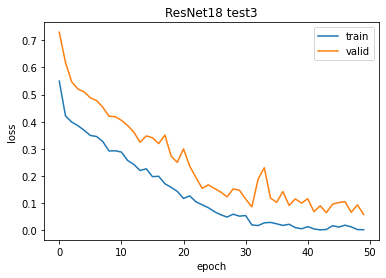

In [51]:
plot_loss_graph(train_loss2,valid_loss2,"ResNet18 test3")

In [52]:
test_accuracy(model2)

model accuracy on the 345 test images: 80.8695652173913 %


In [5]:
from skimage.transform import resize
knn_data_set = []
label_data_array = []
classes = ['cheetah', 'fox', 'hyena', 'lion', 'tiger', 'wolf']
def process_train_data():
    for _class in tqdm(classes):
        _folder_path = os.path.join(images_path,_class)
        _number_class = classes.index(_class)
        for _image in os.listdir(_folder_path):
            _image_arr = cv2.imread(os.path.join(_folder_path,_image))
            _img_rsz=resize(_image_arr,(32,32,3))
            knn_data_set.append(_img_rsz.flatten())
            label_data_array.append(_number_class)
            
            
process_train_data()

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
knn_data_set = np.array(knn_data_set)
label_data_array = np.array(label_data_array)

In [24]:
knn_data_set = knn_data_set.reshape(knn_data_set.shape[0], -1)

In [25]:
from sklearn.model_selection import  train_test_split
(X_train, X_Test, Y_Train, Y_Test) = train_test_split(knn_data_set, label_data_array, test_size= 0.20, random_state=30)

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
model3 = KNeighborsClassifier(n_neighbors=4,weights='uniform', algorithm='auto', leaf_size=30)
model3.fit(X_train, Y_Train)
knn_predict = model3.predict(X_Test)
print(classification_report(Y_Test, model3.predict(X_Test), target_names=['cheetah', 'fox', 'hyena', 'lion', 'tiger', 'wolf']))

              precision    recall  f1-score   support

     cheetah       0.27      0.79      0.41        68
         fox       0.31      0.21      0.25        47
       hyena       0.33      0.21      0.25        62
        lion       0.57      0.25      0.35        64
       tiger       0.28      0.14      0.19        50
        wolf       0.50      0.20      0.29        54

    accuracy                           0.32       345
   macro avg       0.38      0.30      0.29       345
weighted avg       0.38      0.32      0.30       345



In [75]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.4f' % accuracy_score(Y_Test,knn_predict))

Accuracy: 0.3217
